# PROJECT #0

## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
!pip install patchworklib
import patchworklib as pw

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

<Figure size 100x100 with 0 Axes>

## Importing Data

New York Housing Data: https://www.kaggle.com/datasets/nelgiriyewithana/new-york-housing-market

NYC Rat Sightings: https://www.kaggle.com/datasets/new-york-city/nyc-rat-sightings

In [2]:
rat_data = pd.read_csv("/content/Rat_Sightings.csv.zip")

house_data = pd.read_csv("/content/NY-House-Dataset.csv.zip")

## Cleaning/Merging Data
Our rat dataset contains reports of when and where rats have been spotted in New York City. We will be grouping the number of rats seen by the street they were seen on, and then adding this data to the NYC housing market data. This may not be perfectly representative of whether a house has a rat problem, but merging by longitude/latitude did not work between the datasets, so this is the most appropraite level to use.

In order to marge our datasets together on the street names, we will need to ensure that each table uses the same street name formatting.

In [3]:
#grouping rat observations by street they were seen on
rat_street_counts = rat_data.groupby(['Street Name']).size().reset_index(name='Rat Sighting Count')
rat_street_counts['Street Name'] = rat_street_counts['Street Name'].str.title() #correcting capitalization to match from housing dataset
display(rat_street_counts.head())

,Street Name,Rat Sighting Count
0,1 Avenue,153
1,1 Court,1
2,1 Place,4
3,1 Street,16
4,10 Avenue,67


In [4]:
#formatting of rat data addresses to match formats in housing data
#ex: East 55 Street --> East 55th Street
#Chat GPT helped generate the regex code used to fix this formatting

# Function to add ordinal suffix
def add_suffix(num: int) -> str:
    if 10 <= num % 100 <= 20:  # handle 11th, 12th, 13th
        suffix = "th"
    else:
        suffix = {1: "st", 2: "nd", 3: "rd"}.get(num % 10, "th")
    return f"{num}{suffix}"

# Regex replacement for multiple street types
def fix_street_name(name: str) -> str:
    return re.sub(
        r"\b(\d+)\s+(Street|Avenue|Road|Lane|Drive|Boulevard|Court|Place|Way)\b",
        lambda m: add_suffix(int(m.group(1))) + " " + m.group(2),
        name
    )

# Apply transformation
rat_street_counts["Street Name"] = rat_street_counts["Street Name"].apply(fix_street_name)

In [5]:
#Some houses have a street name listed as one of the NYC burroughs or just New York itself
#In these cases, we will be replacing the street name with LONG_NAME, which will sometimes have the correct street name to match rat dat

# Define the borough names
boroughs = ["Manhattan", "Brooklyn", "Queens", "The Bronx", "Staten Island", "New York"]

# Replace STREET_NAME with LONG_NAME if STREET_NAME is a borough
house_data['STREET_NAME'] = house_data.apply(
    lambda row: row['LONG_NAME'] if row['STREET_NAME'] in boroughs else row['STREET_NAME'],
    axis=1
)

In [6]:
#now that data has been cleaned and the formatting of the street names in each table match each other, we can merge on street names

merged_data = pd.merge(
        house_data,
        rat_street_counts,
        left_on='STREET_NAME',
        right_on='Street Name',
        how='left')

display(merged_data.head())

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE,Street Name,Rat Sighting Count
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483,East 55th Street,21.0
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,West 57th Street,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991,West 57th Street,12.0
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Sinclair Avenue,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109,Sinclair Avenue,3.0
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.0,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,East 55th Street,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613,East 55th Street,21.0
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.0,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,East 64th Street,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856,East 64th Street,19.0


In [7]:
#any street names that do not match after these steps will be treated as having zero rat observations there

merged_data['Rat Sighting Count'] = merged_data['Rat Sighting Count'].fillna(0)
merged_data['Rat Sighting Count'] = merged_data['Rat Sighting Count'].astype(int)

merged_data['Rat Sighting Count'].value_counts()

,count
Rat Sighting Count,
0,2555
1,170
2,126
4,72
10,68
...,...
301,1
247,1
286,1


In [8]:
#dropping the extra street name column that has been created
merged_data = merged_data.drop(columns=['Street Name'])
merged_data.sort_values(by='Rat Sighting Count', ascending=False)

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE,Rat Sighting Count
4759,Brokered by COMPASS,Co-op for sale,275000,2,1.000000,815.000000,800 Grand Concourse Apt Gms,"Bronx, NY 10451","800 Grand Concourse Apt GmsBronx, NY 10451",United States,New York,Bronx County,Grand Concourse,Grand Concourse,"800 Grand Concourse, Bronx, NY 10451, USA",40.824870,-73.922983,713
1611,Brokered by Pantiga Group Inc.,Co-op for sale,259000,2,1.000000,950.000000,800 Grand Concourse Ave Unit Gjn,"Bronx, NY 10451","800 Grand Concourse Ave Unit GjnBronx, NY 10451",United States,New York,Bronx County,Grand Concourse,Grand Concourse,"800 Grand Concourse, Bronx, NY 10451, USA",40.824870,-73.922983,713
2097,Brokered by COMPASS,House for sale,3999500,3,2.373861,2184.207862,1800 Grand Concourse,"Bronx, NY 10457","1800 Grand ConcourseBronx, NY 10457",United States,New York,Bronx County,Grand Concourse,Grand Concourse,"1800 Grand Concourse, Bronx, NY 10457, USA",40.847049,-73.908012,713
495,Brokered by Douglas Elliman - 1995 Broadway,Condo for sale,16500000,5,4.000000,4105.000000,2150 Broadway,"New York, NY 10023","2150 BroadwayNew York, NY 10023",United States,New York,New York County,Broadway,Broadway,"2150 Broadway, New York, NY 10023, USA",40.781460,-73.980686,705
2313,Brokered by Corcoran Long Island City,Condo for sale,950000,2,2.000000,1025.000000,1215 Broadway Apt 320,"Queens, NY 11106","1215 Broadway Apt 320Queens, NY 11106",United States,New York,Queens County,Broadway,Broadway,"12-15 Broadway, Long Island City, NY 11106, USA",40.766913,-73.934289,705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,Brokered by Keller Williams Realty Greater Nassau,Co-op for sale,198000,1,1.000000,2184.207862,65-15 Alderton St Unit 1A,"Rego Park, NY 11374","65-15 Alderton St Unit 1ARego Park, NY 11374",New York,Queens County,Queens,Rego Park,65-15,"65-15 Alderton St #1a, Rego Park, NY 11374, USA",40.720847,-73.858929,0
2599,Brokered by DIGS - Digs Realty Group EMAIL),Co-op for sale,779000,1,1.000000,800.000000,321 W 90th St Apt 8D,"New York, NY 10024","321 W 90th St Apt 8DNew York, NY 10024",New York,New York County,New York,321,321,"321 W 90th St #8d, New York, NY 10024, USA",40.792004,-73.976782,0
2601,Brokered by EXIT REALTY PRIVATE CLIENT,House for sale,509000,3,1.000000,1100.000000,3054 Lawton Ave,"Bronx, NY 10465","3054 Lawton AveBronx, NY 10465",United States,New York,Bronx County,Lawton Avenue,Lawton Avenue,"3054 Lawton Ave, Bronx, NY 10465, USA",40.818143,-73.810545,0
2602,"Brokered by Nest Seekers International, Midtown",Condo for sale,499000,1,1.000000,845.000000,2068 Ocean Ave Apt 2B,"Brooklyn, NY 11230","2068 Ocean Ave Apt 2BBrooklyn, NY 11230",New York,Kings County,Brooklyn,Midwood,2068,"2068 Ocean Ave #2b, Brooklyn, NY 11230, USA",40.611469,-73.954103,0


In [9]:
#removing land for sale as we strictly want to look at built properties
merged_data = merged_data[merged_data['TYPE'] != 'Land for sale']
merged_data['TYPE'].value_counts()

#eliminating extreme outliers
merged_data = merged_data[merged_data['PRICE'] < 2000000]
merged_data = merged_data[merged_data['PROPERTYSQFT'] < 40000]

# Exploratory Data Analysis

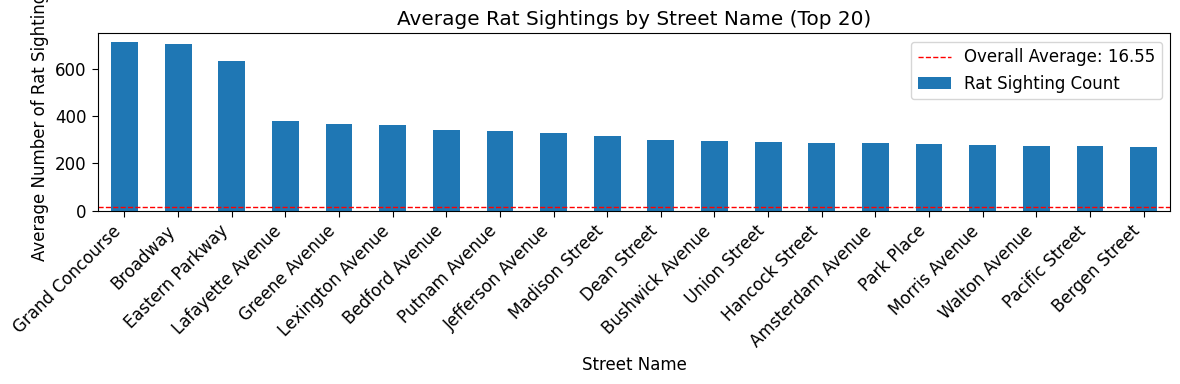

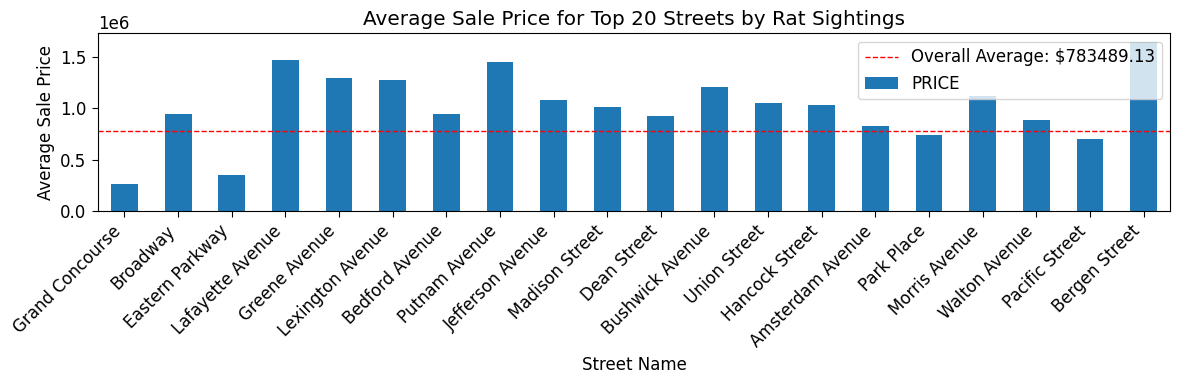

In [10]:
try: #try and except were used to eliminate an ignoring error in the pathworklib library
  rat_sightings_by_street = merged_data.groupby('STREET_NAME')['Rat Sighting Count'].mean().sort_values(ascending=False)

  p1 = plt.figure(figsize=(12, 4))
  rat_sightings_by_street.head(20).plot(kind='bar') # Display top 20 streets for better visualization
  plt.title('Average Rat Sightings by Street Name (Top 20)')
  plt.xlabel('Street Name')
  plt.ylabel('Average Number of Rat Sightings')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  # Add horizontal line for overall average rat sightings
  avg_rat_sightings = merged_data['Rat Sighting Count'].mean()
  plt.axhline(avg_rat_sightings, color='red', linestyle='dashed', linewidth=1, label=f'Overall Average: {avg_rat_sightings:.2f}')
  plt.legend()


  avg_sale_price_by_street = merged_data.groupby('STREET_NAME')['PRICE'].mean()
  # Filter avg_sale_price_by_street to include only the top 20 streets by rat sightings
  top_20_streets = rat_sightings_by_street.head(20).index
  avg_sale_price_for_top_streets = avg_sale_price_by_street[top_20_streets].reindex(top_20_streets)


  p2 = plt.figure(figsize=(12, 4))
  avg_sale_price_for_top_streets.plot(kind='bar')
  plt.title('Average Sale Price for Top 20 Streets by Rat Sightings')
  plt.xlabel('Street Name')
  plt.ylabel('Average Sale Price')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  # Add horizontal line for overall average sale price
  avg_sale_price = merged_data['PRICE'].mean()
  plt.axhline(avg_sale_price, color='red', linestyle='dashed', linewidth=1, label=f'Overall Average: ${avg_sale_price:.2f}')
  plt.legend()


  combined = pw.load_matplotlib(p1) | pw.load_matplotlib(p2)

  combined.show()
except:
  pass

In comparing the top 20 streets with the most rat sightings, we see there seems to be no clear pattern to average sale prices on these streets as well. This likely means that rat sightings is not a great predictor of property price, as there are many other conditions.

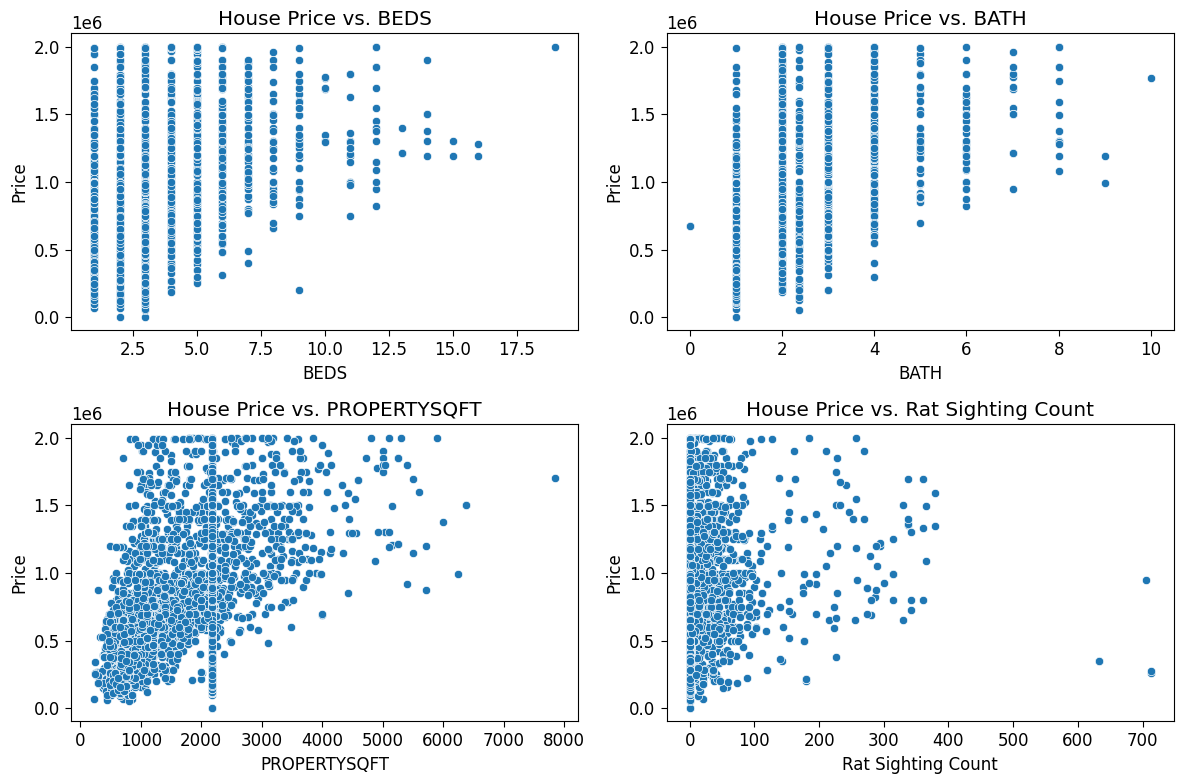

In [11]:
# Create a scatterplot matrix
features = ['BEDS', 'BATH', 'PROPERTYSQFT', 'Rat Sighting Count']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(data=merged_data, x=feature, y='PRICE')
    plt.title(f'House Price vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('Price')

plt.tight_layout()
plt.show()

There appears to be the strongest linear relationship between PROPERTYSQFT and Price, which means it will likely be the best predictor of price. Our other variables show some positive linear relationship, though they are certainly much weaker. This could possibly be improved by transforming data, though I am cautious to do this in fear of hurting performance of nonparametric models, so I will leave them untransformed for now.

In [33]:
#cutting dataset down to only features that will be used in model
model_data = merged_data[['PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'Rat Sighting Count']]
model_data.head()

,PRICE,BEDS,BATH,PROPERTYSQFT,Rat Sighting Count
0,315000,2,2.0,1400.000000,21
2,260000,4,2.0,2015.000000,3
3,69000,3,1.0,445.000000,21
5,690000,5,2.0,4004.000000,280
6,899500,2,2.0,2184.207862,0


# Creating Test/Training Splits

In [34]:
y = model_data['PRICE']
X = model_data[['BEDS', 'BATH', 'PROPERTYSQFT', 'Rat Sighting Count']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2732, 4), (1171, 4), (2732,), (1171,))

## Linear Regression

Multi-Linear Regression is a model I am fairly familiar with, so I will be trying it first on my data. Given that many of my features do not have very strong linear relationships with sale price, I am not expecting outstanding results, but it will still be a very important model to consider given its ease of interpretability. I also wanted to compare a parametric model to nonparametric models.

In [35]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
coefficients = lr.coef_

print("Linear Regression Model Evaluation:")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")
print("\nCoefficients:")
for feature, coef in zip(X.columns, coefficients):
    print(f"{feature}: {coef}")

Linear Regression Model Evaluation:
Root Mean Squared Error: 353910.9838253715
R-squared: 0.35880397524644525

Coefficients:
BEDS: 6339.800398765182
BATH: 177497.1146960103
PROPERTYSQFT: 89.50959287348087
Rat Sighting Count: 410.08844472511555


## K Nearest Neighbors Regression

KNN Regression is the next model I will be using on my data, which I expect to have better predicting power at the sacrafice of interpretability. If the predictive results far exceed those of multi-linear regression, then this could be a great option.

In [25]:
#originally tried model with default parameters of k=5, but I later found the model to perform best at k=30

def evaluate_model(model, X_val, y_val):
  y_pred = model.predict(X_val)
  rmse = np.sqrt(mean_squared_error(y_val, y_pred))
  r2 = r2_score(y_val, y_pred)
  print(f"{model.__class__.__name__} RMSE: {rmse}")
  print(f"{model.__class__.__name__} R2 Score: {r2}")

knn = KNeighborsRegressor(n_neighbors=30)
knn.fit(X_train, y_train)
evaluate_model(knn, X_test, y_test)

KNeighborsRegressor RMSE: 346268.18433354504
KNeighborsRegressor R2 Score: 0.3861985390596271


In [31]:
#permutation importance reflects which feature had the greatest impact on the target variable

from sklearn.inspection import permutation_importance

results = permutation_importance(knn, X_test, y_test, scoring='r2', n_repeats=10, random_state=42)

for feature, importance in zip(X_test.columns, results.importances_mean):
    print(f"{feature}: {importance:.4f}")

BEDS: 0.0519
BATH: 0.1217
PROPERTYSQFT: 0.5618
Rat Sighting Count: 0.0370


## Random Forest Regression

I wanted to compare another nonparametric model, and chose Random Forest Regression as it may offer great predictive accuracy. It is once again not very interpretable, so that may be an issue in finally selecting a model.

In [30]:
#originally tried with the default n_estimators=100, though trying with more n_estimators provided the best results at 500

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test)

RandomForestRegressor RMSE: 350718.3141211703
RandomForestRegressor R2 Score: 0.37032039342476375


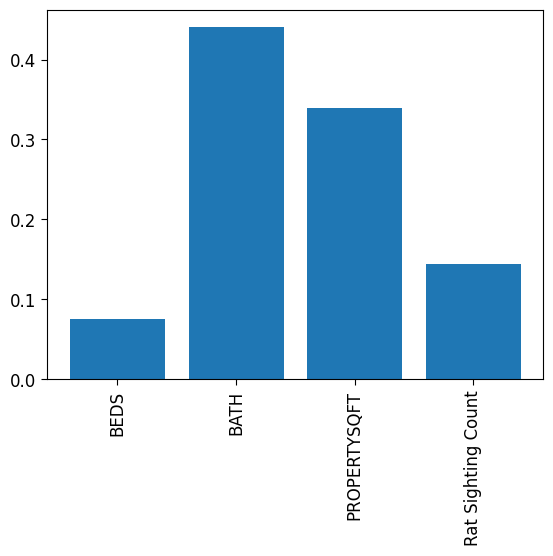

In [32]:
#feature importance plot to compare features
plt.bar(x=X.columns,height=rf.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

# For further discussion, please see report